In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score
import os
import datetime

# ================== 1. 数据加载与预处理 ==================
# 读取板块指数数据
semi_con_index = pd.read_excel(r'D:\个人作业集\大数据个人作业\过程数据\semi_con_index.xlsx')

# 读取情绪指数数据
sentiment = pd.read_csv(r'D:\个人作业集\大数据个人作业\过程数据\reviewed_daily_sentiment_index.csv', encoding='utf-8')

# 标准化日期格式
semi_con_index['date'] = pd.to_datetime(semi_con_index['日期'])
sentiment['date'] = pd.to_datetime(sentiment['date'])

In [2]:
# ================== 2. 日期匹配（仅保留交易日） ==================
df = pd.merge(
    semi_con_index[['date', '涨跌幅']],
    sentiment[['date', 'sentiment_index']],
    on='date',
    how='inner'
)
df = df.sort_values('date').reset_index(drop=True)

print(f"✅ 匹配后数据量: {len(df)} 条交易日数据")
print(f"📅 日期范围: {df['date'].min()} 到 {df['date'].max()}")
# ================== 3. 添加滞后变量 ==================
df['lag_sentiment'] = df['sentiment_index'].shift(1)
df['lag_return'] = df['涨跌幅'].shift(1)
df = df.dropna(subset=['lag_sentiment', 'lag_return']).reset_index(drop=True)


✅ 匹配后数据量: 829 条交易日数据
📅 日期范围: 2022-07-01 00:00:00 到 2025-11-28 00:00:00


In [3]:
# ================== 4. 变量统计性描述（新增） ==================
# 情绪指数描述性统计
sentiment_desc = df['sentiment_index'].describe().to_frame().T
sentiment_desc.index = ['情绪指数统计描述']

# 板块涨跌幅描述性统计
return_desc = df['涨跌幅'].describe().to_frame().T
return_desc.index = ['板块涨跌幅统计描述']

# 合并描述性统计
desc_df = pd.concat([sentiment_desc, return_desc])

# 打印统计描述
print("\n📊 变量统计性描述:")
print(desc_df.round(4))

# ================== 5. 相关性分析 ==================
# 当期情绪指数 vs 板块涨跌幅
corr_current = df['sentiment_index'].corr(df['涨跌幅'])
print(f"\n📌 当期情绪指数与板块涨跌幅相关系数: {corr_current:.4f} (p-value: {sm.OLS(df['涨跌幅'], df['sentiment_index']).fit().pvalues[0]:.6f})")

# 滞后1期情绪指数 vs 板块涨跌幅
corr_lag = df['lag_sentiment'].corr(df['涨跌幅'])
print(f"📌 滞后1期情绪指数与板块涨跌幅相关系数: {corr_lag:.4f} (p-value: {sm.OLS(df['涨跌幅'], df['lag_sentiment']).fit().pvalues[0]:.6f})")

# 滞后涨跌幅动量效应
corr_lag_return = df['lag_return'].corr(df['涨跌幅'])
print(f"📌 滞后1期板块涨跌幅与当日涨跌幅相关系数: {corr_lag_return:.4f} (p-value: {sm.OLS(df['涨跌幅'], df['lag_return']).fit().pvalues[0]:.6f})")


📊 变量统计性描述:
           count    mean     std     min     25%     50%     75%     max
情绪指数统计描述   828.0 -0.0017  0.0044 -0.0205 -0.0036 -0.0016  0.0001  0.0242
板块涨跌幅统计描述  828.0  0.0003  0.0207 -0.1029 -0.0109 -0.0004  0.0106  0.1540

📌 当期情绪指数与板块涨跌幅相关系数: 0.0768 (p-value: 0.055785)
📌 滞后1期情绪指数与板块涨跌幅相关系数: -0.0170 (p-value: 0.540559)
📌 滞后1期板块涨跌幅与当日涨跌幅相关系数: 0.0953 (p-value: 0.005922)


C:\Users\mazal\AppData\Local\Temp\ipykernel_50028\2704960948.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"\n📌 当期情绪指数与板块涨跌幅相关系数: {corr_current:.4f} (p-value: {sm.OLS(df['涨跌幅'], df['sentiment_index']).fit().pvalues[0]:.6f})")
C:\Users\mazal\AppData\Local\Temp\ipykernel_50028\2704960948.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"📌 滞后1期情绪指数与板块涨跌幅相关系数: {corr_lag:.4f} (p-value: {sm.OLS(df['涨跌幅'], df['lag_sentiment']).fit().pvalues[0]:.6f})")
C:\Users\mazal\AppData\Local\Temp\ipykernel_50028\2704960948.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a f

In [4]:
# ================== 6. 因果回归分析 ==================
# 模型1: 仅用滞后情绪指数预测
X1 = df[['lag_sentiment']]
X1 = sm.add_constant(X1)
model1 = sm.OLS(df['涨跌幅'], X1).fit()

# 模型2: 用当期情绪指数预测
X2 = df[['sentiment_index']]
X2 = sm.add_constant(X2)
model2 = sm.OLS(df['涨跌幅'], X2).fit()

# 模型3: 当期+滞后情绪指数
X3 = df[['sentiment_index', 'lag_sentiment']]
X3 = sm.add_constant(X3)
model3 = sm.OLS(df['涨跌幅'], X3).fit()

# 模型4: 滞后情绪+滞后涨跌幅
X4 = df[['lag_sentiment', 'lag_return']]
X4 = sm.add_constant(X4)
model4 = sm.OLS(df['涨跌幅'], X4).fit()

# 打印回归结果
print("\n📊 回归分析结果:")
print(f"模型1 (滞后1期情绪): R²={model1.rsquared:.4f}, p={model1.f_pvalue:.6f}")
print(f"模型2 (当期情绪): R²={model2.rsquared:.4f}, p={model2.f_pvalue:.6f}")
print(f"模型3 (当期+滞后情绪): R²={model3.rsquared:.4f}, p={model3.f_pvalue:.6f}")
print(f"模型4 (滞后情绪+滞后涨跌幅): R²={model4.rsquared:.4f}, p={model4.f_pvalue:.6f}")


📊 回归分析结果:
模型1 (滞后1期情绪): R²=0.0003, p=0.625172
模型2 (当期情绪): R²=0.0059, p=0.027083
模型3 (当期+滞后情绪): R²=0.0067, p=0.062702
模型4 (滞后情绪+滞后涨跌幅): R²=0.0097, p=0.018033


In [5]:
# ================== 7. 实证结果存储（关键新增） ==================
# 创建结果DataFrame
results = pd.DataFrame({
    '模型': ['滞后1期情绪', '当期情绪', '当期+滞后情绪', '滞后情绪+滞后涨跌幅'],
    'R²': [model1.rsquared, model2.rsquared, model3.rsquared, model4.rsquared],
    'p值': [model1.f_pvalue, model2.f_pvalue, model3.f_pvalue, model4.f_pvalue],
    '情绪系数': [model1.params['lag_sentiment'] if 'lag_sentiment' in model1.params else np.nan,
                model2.params['sentiment_index'] if 'sentiment_index' in model2.params else np.nan,
                model3.params['sentiment_index'] if 'sentiment_index' in model3.params else np.nan,
                model4.params['lag_sentiment'] if 'lag_sentiment' in model4.params else np.nan],
    '涨跌幅系数': [np.nan, np.nan, np.nan, model4.params['lag_return'] if 'lag_return' in model4.params else np.nan],
    '情绪系数p值': [model1.pvalues['lag_sentiment'] if 'lag_sentiment' in model1.pvalues else np.nan,
                   model2.pvalues['sentiment_index'] if 'sentiment_index' in model2.pvalues else np.nan,
                   model3.pvalues['sentiment_index'] if 'sentiment_index' in model3.pvalues else np.nan,
                   model4.pvalues['lag_sentiment'] if 'lag_sentiment' in model4.pvalues else np.nan],
    '涨跌幅系数p值': [np.nan, np.nan, np.nan, model4.pvalues['lag_return'] if 'lag_return' in model4.pvalues else np.nan]
})

# 保存到Excel文件（包含统计描述和回归结果）
output_dir = r'D:\个人作业集\大数据个人作业\实证结果'
os.makedirs(output_dir, exist_ok=True)

# 保存统计描述
desc_df.to_excel(os.path.join(output_dir, '变量统计描述.xlsx'), index=True)

# 保存回归结果
results.to_excel(os.path.join(output_dir, '回归分析结果.xlsx'), index=False)

print(f"\n✅ 实证结果已保存到: {output_dir}")
print(f"  - 变量统计描述: {os.path.join(output_dir, '变量统计描述.xlsx')}")
print(f"  - 回归分析结果: {os.path.join(output_dir, '回归分析结果.xlsx')}")


✅ 实证结果已保存到: D:\个人作业集\大数据个人作业\实证结果
  - 变量统计描述: D:\个人作业集\大数据个人作业\实证结果\变量统计描述.xlsx
  - 回归分析结果: D:\个人作业集\大数据个人作业\实证结果\回归分析结果.xlsx


C:\Users\mazal\AppData\Local\Temp\ipykernel_50028\2610358277.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(df['lag_sentiment'], model1.params[0] + model1.params[1]*df['lag_sentiment'], 'r-', linewidth=2)
C:\Users\mazal\AppData\Local\Temp\ipykernel_50028\2610358277.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(df['sentiment_index'], model2.params[0] + model2.params[1]*df['sentiment_index'], 'r-', linewidth=2)


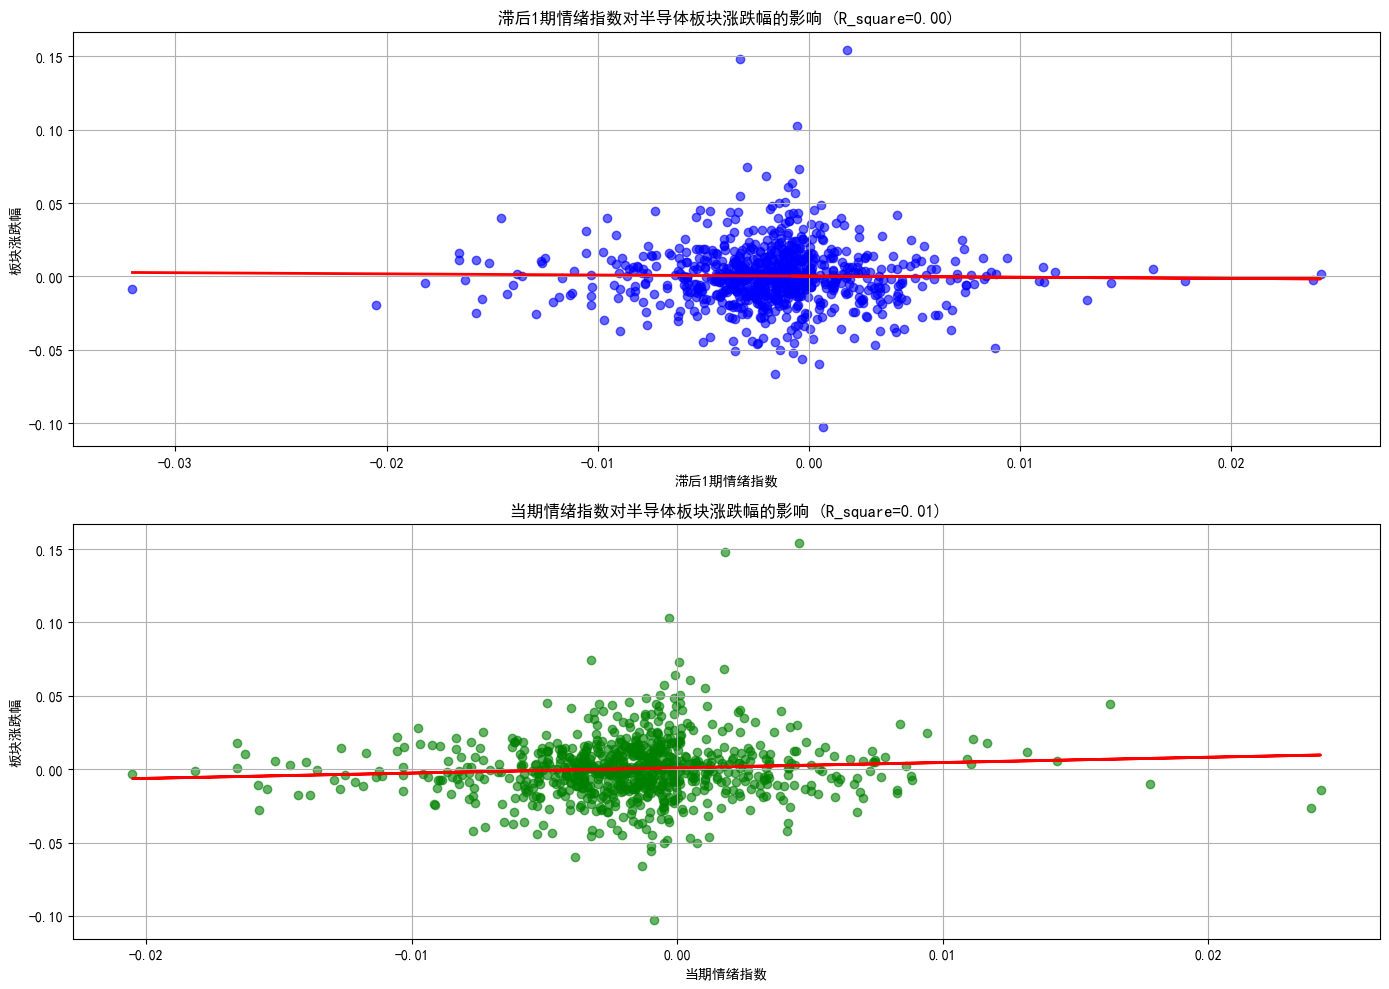

In [7]:
# ================== 8. 可视化（保持原样） ==================
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(14, 10))

# 子图1: 滞后情绪指数 vs 板块涨跌幅
plt.subplot(2, 1, 1)
plt.scatter(df['lag_sentiment'], df['涨跌幅'], alpha=0.6, color='blue')
plt.plot(df['lag_sentiment'], model1.params[0] + model1.params[1]*df['lag_sentiment'], 'r-', linewidth=2)
plt.title('滞后1期情绪指数对半导体板块涨跌幅的影响 (R_square={:.2f})'.format(model1.rsquared), fontsize=12)
plt.xlabel('滞后1期情绪指数', fontsize=10)
plt.ylabel('板块涨跌幅', fontsize=10)
plt.grid(True)

# 子图2: 当期情绪指数 vs 板块涨跌幅
plt.subplot(2, 1, 2)
plt.scatter(df['sentiment_index'], df['涨跌幅'], alpha=0.6, color='green')
plt.plot(df['sentiment_index'], model2.params[0] + model2.params[1]*df['sentiment_index'], 'r-', linewidth=2)
plt.title('当期情绪指数对半导体板块涨跌幅的影响 (R_square={:.2f})'.format(model2.rsquared), fontsize=12)
plt.xlabel('当期情绪指数', fontsize=10)
plt.ylabel('板块涨跌幅', fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.savefig(r'D:\个人作业集\大数据个人作业\实证结果\情绪影响可视化.png', dpi=300)
plt.show()